<a href="https://colab.research.google.com/github/VinodKumar9576/TMDB-Prediction/blob/master/TMDB Prediction/Data Extraction.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [0]:
!pip install swifter

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import swifter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Keep your **Kaggle** Username and API key ready to download the dataset.
* Im following this method coz i don't want to store the actual data in google drive.
* Instead of below cell, you can just download and data set in drive and can read it directly after mounting drive in colab.
* When you run below cell, it'll prompt you to give username and api key, provide them.

In [0]:
import getpass as gt

user = input('Provide Kaggle Username : ')
api = gt.getpass('API key for '+ user +' :')
print('')

!mkdir ~/.kaggle

!touch /root/.kaggle/kaggle.json

kaggle_api_key = {'username':user, 'key':api}


!chmod 600 /root/.kaggle/kaggle.json

import json

with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(kaggle_api_key, file)


!kaggle datasets download -d vinodkumar9576/tmdbboxofficeprediction

from zipfile import ZipFile

for names in ZipFile('/content/tmdbboxofficeprediction.zip').namelist():
  print(names)

Provide Kaggle Username : vinodkumar9576
API key for vinodkumar9576 :··········

 63% 11.0M/17.4M [00:00<00:00, 55.5MB/s]
100% 17.4M/17.4M [00:00<00:00, 69.1MB/s]
sample_submission.csv
test.csv
train.csv


* In the above cell data has been downloaded and stored in colab session(after session ends, data will be gone) and filenames also got listed in downloaded zip.
* Below is to read the files from downloaded zip and to store them in df variables.

In [0]:
#Reading the train.csv from zipfile
with ZipFile('/content/tmdbboxofficeprediction.zip') as zip:
  train_df = pd.read_csv(zip.open('train.csv'))
  test_df = pd.read_csv(zip.open('test.csv'))

In [0]:
train_df.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


* As you can see, many columns eg: **belongs_to_collection** has data in dictionary format.
* Over below we'll extract required information from these dictionaries and make new columns.

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

* We can see most of the columns in train_df are of *object* type.
* Lets see the kind of data stored in these columns.

**<h3>Declaring the project path**

In [0]:
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/'

#**Exploring the features**

* Lets make copies of train and test data sets.
* By doing this we don't loose the original data and if anything goes wrong in duplicate data, we can fetch again from original data.

In [0]:
train_cp = train_df.copy()
test_cp = test_df.copy()

In [0]:
train_cp.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [0]:
test_cp.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."


**<h4>Working on each feature**

* Following below, we are doing the preprocessing of datasets.
* Whatever we do for train data set to test data set also.

For each feature in the dataset that has a data point that belong to more than one category in single feature we do the below steps:
* Printing first 5 values to see the type of data.
* Checking the distribution of count of companies.
* Printing top relevant number categories.
* making those many top categories as columns/feaures with binary encoding.

**<h4>Swifter**

* We use this for parallelising operations on data frame.
* Comes in handy when you are dealing with very large data frame where it takes more time to do operations on df during preprocessing.
* General operations go by serial wise whereas after using swifter:
  * Dataframe is split into chunks according to the number of cpus available.
  * Each chunk is operated with same specified function on each core/cpu.
  * Finally, all the chunks are merged again with final modified data.
  * Note that during this operation, order of data points do not change.
* You can find the application of **swifter** over below.

Please refer the link if you wish to check out more on **swifter**:
<br>
https://mlwhiz.com/blog/2020/02/20/swifter/

#**Belongs to collection**

* For series movies like **Avengers** collection name is single and movies in it has different names.
* For movies that don't have sequels, movie name is same as collection name.
* We are extracting **name of collection** and a binary column that denotes whether a movie has collection or not i.e. whether a movie has sequels or not.
* Finally dropping the **belongs_to_collection** column.

In [0]:
#for train data
train_cp['Collection_name'] = train_cp['belongs_to_collection'].swifter.apply(lambda x:literal_eval(x)[0]
                                                                         .get('name') if not (pd.isnull(x)) else 0)

train_cp['has collection'] = train_cp['belongs_to_collection'].swifter.apply(lambda x:len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#for test data
test_cp['Collection_name'] = test_cp['belongs_to_collection'].swifter.apply(lambda x:literal_eval(x)[0]
                                                                         .get('name') if not (pd.isnull(x)) else 0)

test_cp['has collection'] = test_cp['belongs_to_collection'].swifter.apply(lambda x:len(literal_eval(x)) if not (pd.isnull(x)) else 0)

train_cp = train_cp.drop(['belongs_to_collection'], axis =1)
test_cp = test_cp.drop(['belongs_to_collection'], axis =1)

In [0]:
train_cp.head(2)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1


In [0]:
test_cp.head(2)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,Collection_name,has collection
0,3001,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1
1,3002,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0


#**Genres**

* A movie may belong to different genres such as 'comedy', 'action', 'thriller' etc.
* We extract all such genre names of each movie and store these genre names in the form of a list for each movie.
* Also making a column that denotes to number of genres a movie belong to.
* Finally dropping the **genre** column.

* Printing first 5 genres

In [0]:
for i,e in enumerate(train_cp['genres'][:5]):
  print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


* We see that there are one or more genres for each movie and we'll print the number of genres in the entire dataset.

In [0]:
print('Number of genres in films')

train_cp['genres'].swifter.apply(lambda x: len(literal_eval(x)) if (x!={} and not (pd.isnull(x))) else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

* See the distribution of genres above.
* Movies with 2,3 genres are about 972 and 900.
* Most of the films have genres 2-3 and 5-6 genres are also possible.
* Genres 0, 7 are outliers as they are very less.

* Making list of genres and showing them in image to know the most listed genre among the movies.

In [0]:
list_of_genres = list(train_cp['genres'].swifter.apply(lambda x: [gen.get('name') for gen in literal_eval(x)]
                                               if (x!={} and not (pd.isnull(x))) else []).values)

In [0]:
list_of_genres[:10]

[['Comedy'],
 ['Comedy', 'Drama', 'Family', 'Romance'],
 ['Drama'],
 ['Thriller', 'Drama'],
 ['Action', 'Thriller'],
 ['Animation', 'Adventure', 'Family'],
 ['Horror', 'Thriller'],
 ['Documentary'],
 ['Action', 'Comedy', 'Music', 'Family', 'Adventure'],
 ['Comedy', 'Music']]

**Word Cloud**
* Wordcloud is a data visualization technique, used for representing text data in which size of each word denotes the frequency or importance.
* Mostly used for analyzing data from social networking sites.
* Lets see about the few parameters that are used in it:
 * **background_color** : specifies the background color for the visual. Default : black.
 * **collocations** : default = True, whether to include bigrams or collocation of two words.
 * **max_font_size** : Default = None. Max font size for the largest word. If *None* height of the image is used as max_font_size.


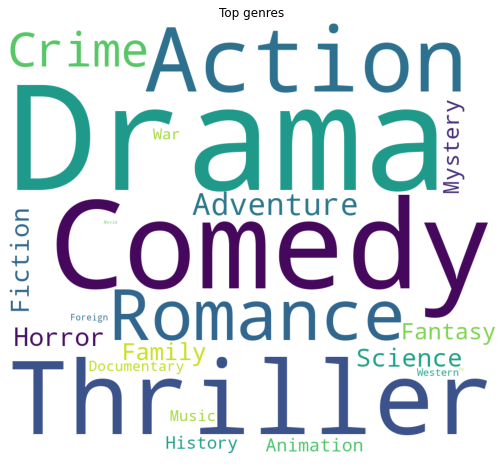


Showing the count of each genre:



[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [0]:
from wordcloud import WordCloud
plt.figure(figsize = (12,8))
#joining all the available genres in list_of_genres
text = ' '.join([i for j in list_of_genres for i in j])

#collocations : whether to include bigrams
wordcloud = WordCloud(background_color='white', collocations=False,
                      width = 900, height=800).generate(text)

plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis('off')
plt.show()w

print('\nShowing the count of each genre:\n')
from collections import Counter
Counter([i for j in list_of_genres for i in j]).most_common()

* We can see Drama, Comedy, Thriller are the most popular genres.
* We'll make new columns for genres with top 15 genres. We are doing this coz, we can't encode the genres as some movies are having more than one genre.

In [0]:
#for train data

#making a column to show no. of genres for each movie
train_cp['num_genres'] = train_cp['genres'].swifter.apply(lambda x : len(literal_eval(x)) if (x!={} and not(pd.isnull(x))) else 0)

#extracting the genres for the movies and sorting them
train_cp['all_genres'] = train_cp['genres'].swifter.apply(lambda x:' '.join(sorted([gen.get('name') for gen in literal_eval(x)])) if (x!={} and not(pd.isnull(x))) else '')

#storing the top 15 genres
#most_common returns the touple with text and its frequency
# from it we are extracting only text so m[0]
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]

#making columns of each most freq genre
for g in top_genres:
  train_cp['genre_'+g] = train_cp['all_genres'].swifter.apply(lambda x:1 if g in x else 0)


#for test data
test_cp['num_genres'] = test_cp['genres'].swifter.apply(lambda x : len(literal_eval(x)) if (x!={} and not(pd.isnull(x))) else 0)

test_cp['all_genres'] = test_cp['genres'].swifter.apply(lambda x:' '.join(sorted([gen.get('name') for gen in literal_eval(x)])) if (x!={} and not(pd.isnull(x))) else '')

for g in top_genres:
  test_cp['genre_'+g] = test_cp['all_genres'].swifter.apply(lambda x:1 if g in x else 0)


#dropping the original features
train_cp = train_cp.drop(['genres'], axis =1)
test_cp = test_cp.drop(['genres'], axis =1)

In [0]:
train_cp.head(2)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0


In [0]:
test_cp.head(2)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


#**Production Companies**

In [0]:
for i,e in enumerate(train_cp['production_companies'][:5]):
  print(i,e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 nan
4 nan


In [0]:
print('No. of production companies :')
train_cp['production_companies'].apply(lambda x: len(literal_eval(x)) if not (pd.isnull(x)) else 0).value_counts()

No. of production companies :


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

* We can see from above analysis, most of the movies have production companies in range 1-3.
* But there are movies with more than 10 companies also.
Lets look at some of them.

In [0]:
train_cp[train_cp['production_companies'].apply(lambda x : len(literal_eval(x)) if not(pd.isnull(x)) else 0) > 11].head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
31,32,0,http://www.cache-derfilm.at,tt0387898,fr,Caché,A married couple is terrorized by a series of ...,5.695860,/i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg,"[{'name': 'Les Films du Losange', 'id': 223}, ...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",5/2/05,117.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Caché,"[{'id': 90, 'name': 'paris'}, {'id': 213, 'nam...","[{'cast_id': 2, 'character': 'Georges Laurent'...","[{'credit_id': '52fe4244c3a36847f8011073', 'de...",36000000,0,0,3,Drama Mystery Thriller,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
116,117,0,NaN,tt2113822,zh,一九四二,"In 1942, Henan Province was devastated by the ...",1.678013,/xxz2gi8vijqqJySGO3kQy2i8mv.jpg,"[{'name': 'Emperor Motion Pictures', 'id': 272...","[{'iso_3166_1': 'CN', 'name': 'China'}]",11/1/12,145.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Back to 1942,"[{'id': 478, 'name': 'china'}, {'id': 180999, ...","[{'cast_id': 3, 'character': 'Theodore Harold ...","[{'credit_id': '5761375dc3a36808aa001554', 'de...",311,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.400049,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
#making the list of companies
list_of_companies = list(train_cp['production_companies'].swifter.apply(lambda x : [i.get('name') for i in literal_eval(x)] if not (pd.isnull(x)) else []).values)

In [0]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

* below will list many values. So we are taking top 30 for which freq is two digit number.
* For now we are just creating binary columns with this 30 companies as features. May be we can use them at later stage when we find them useful.

In [0]:
#for train data

#making a column to show no. of genres for each movie
train_cp['num_companies'] = train_cp['production_companies'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
train_cp['all_production_companies'] = train_cp['production_companies'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if (x!={} and not(pd.isnull(x))) else '')

#storing the top 15 genres
#most_common returns the touple with text and its frequency
# from it we are extracting only text so m[0]
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]

#making columns of each most freq genre
for g in top_companies:
  train_cp['production_company_' + g] = train_cp['all_production_companies'].swifter.apply(lambda x:1 if g in x else 0)


#for test data
test_cp['num_companies'] = test_cp['production_companies'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
test_cp['all_production_companies'] = test_cp['production_companies'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if (x!={} and not(pd.isnull(x))) else '')

#making columns of each most freq genre
for g in top_companies:
  test_cp['production_company_' + g] = test_cp['all_production_companies'].swifter.apply(lambda x:1 if g in x else 0)


#dropping the original features
train_cp = train_cp.drop(['production_companies','all_production_companies'], axis =1)
test_cp = test_cp.drop(['production_companies','all_production_companies'], axis =1)

In [0]:
train_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3003,0,NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",0,0,2,Comedy Romance,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#**Production Countries**

In [0]:
for i,e in enumerate(train_cp['production_countries'][:5]):
  print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [0]:
print('No. of countries in the film :')
train_cp['production_countries'].apply(lambda x: len(literal_eval(x)) if not (pd.isnull(x)) else 0).value_counts()

No. of countries in the film :


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

* Normally films will be produced by companies belonging to single country.
* But there there are cases where more than one country is involved in production.

In [0]:
list_of_countries = list(train_cp['production_countries'].apply(lambda x: [i.get('name') for i in literal_eval(x)] if not (pd.isnull(x)) else []).values)

Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [0]:
#for train data

#making a column to show no. of genres for each movie
train_cp['num_countries'] = train_cp['production_countries'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
train_cp['all_production_countries'] = train_cp['production_countries'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#storing the top 15 genres
#most_common returns the touple with text and its frequency
# from it we are extracting only text so m[0]
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(30)]

#making columns of each most freq genre
for g in top_countries:
  train_cp['production_countries_' + g] = train_cp['all_production_countries'].swifter.apply(lambda x:1 if g in x else 0)


#for test data
test_cp['num_countries'] = test_cp['production_countries'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
test_cp['all_production_countries'] = test_cp['production_countries'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#making columns of each most freq genre
for g in top_countries:
  test_cp['production_countries_' + g] = test_cp['all_production_countries'].swifter.apply(lambda x:1 if g in x else 0)


#dropping the original features
train_cp = train_cp.drop(['production_countries','all_production_countries'], axis =1)
test_cp = test_cp.drop(['production_countries','all_production_countries'], axis =1)

In [0]:
train_cp.head(2)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,...,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,production_countries_South Korea,production_countries_Mexico,production_countries_Sweden,production_countries_New Zealand,production_countries_Netherlands,production_countries_Czech Republic,production_countries_Denmark,production_countries_Brazil,production_countries_Luxembourg,production_countries_South Africa,production_countries_Hungary,production_countries_United Arab Emirates,production_countries_Austria,production_countries_Switzerland,production_countries_Romania
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,...,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,production_countries_South Korea,production_countries_Mexico,production_countries_Sweden,production_countries_New Zealand,production_countries_Netherlands,production_countries_Czech Republic,production_countries_Denmark,production_countries_Brazil,production_countries_Luxembourg,production_countries_South Africa,production_countries_Hungary,production_countries_United Arab Emirates,production_countries_Austria,production_countries_Switzerland,production_countries_Romania
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3003,0,NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",0,0,2,Comedy Romance,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#**Spoken Languages**

In [0]:
for i, e in enumerate(train_cp['spoken_languages'][:5]):
  print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [0]:
print('Number of spoken languages')

train_cp['spoken_languages'].apply(lambda x: len(literal_eval(x)) if not pd.isnull(x) else 0).value_counts()

Number of spoken languages


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [0]:
list_of_languages = list(train_cp['spoken_languages'].apply(lambda x: [i.get('name') for i in literal_eval(x)] if not pd.isnull(x) else []).values)

Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [0]:
#for train data

#making a column to show no. of genres for each movie
train_cp['num_languagues'] = train_cp['spoken_languages'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
train_cp['all_languagues'] = train_cp['spoken_languages'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#storing the top 15 genres
#most_common returns the touple with text and its frequency
# from it we are extracting only text so m[0]
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]

#making columns of each most freq genre
for g in top_languages:
  train_cp['languague_' + g] = train_cp['all_languagues'].swifter.apply(lambda x:1 if g in x else 0)


#for test data
test_cp['num_languagues'] = test_cp['spoken_languages'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
test_cp['all_languagues'] = test_cp['spoken_languages'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#making columns of each most freq genre
for g in top_languages:
  test_cp['languague_' + g] = test_cp['all_languagues'].swifter.apply(lambda x:1 if g in x else 0)

#dropping original features
train_cp = train_cp.drop(['spoken_languages', 'all_languagues'], axis = 1)
test_cp = test_cp.drop(['spoken_languages', 'all_languagues'], axis = 1)

In [0]:
train_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,...,production_countries_Denmark,production_countries_Brazil,production_countries_Luxembourg,production_countries_South Africa,production_countries_Hungary,production_countries_United Arab Emirates,production_countries_Austria,production_countries_Switzerland,production_countries_Romania,num_languagues,languague_English,languague_Français,languague_Español,languague_Deutsch,languague_Pусский,languague_Italiano,languague_日本語,languague_普通话,languague_हिन्दी,languague_,languague_Português,languague_العربية,languague_한국어/조선말,languague_广州话 / 廣州話,languague_தமிழ்,languague_Polski,languague_Magyar,languague_Latin,languague_svenska,languague_ภาษาไทย,languague_Český,languague_עִבְרִית,languague_ελληνικά,languague_Türkçe,languague_Dansk,languague_Nederlands,languague_فارسی,languague_Tiếng Việt,languague_اردو,languague_Română
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,113.0,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,105.0,Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,cast,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,...,production_countries_Denmark,production_countries_Brazil,production_countries_Luxembourg,production_countries_South Africa,production_countries_Hungary,production_countries_United Arab Emirates,production_countries_Austria,production_countries_Switzerland,production_countries_Romania,num_languagues,languague_English,languague_Français,languague_Español,languague_Deutsch,languague_Pусский,languague_Italiano,languague_日本語,languague_普通话,languague_हिन्दी,languague_,languague_Português,languague_العربية,languague_한국어/조선말,languague_广州话 / 廣州話,languague_தமிழ்,languague_Polski,languague_Magyar,languague_Latin,languague_svenska,languague_ภาษาไทย,languague_Český,languague_עִבְרִית,languague_ελληνικά,languague_Türkçe,languague_Dansk,languague_Nederlands,languague_فارسی,languague_Tiếng Việt,languague_اردو,languague_Română
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3003,0,NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,5/23/97,100.0,Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",0,0,2,Comedy Romance,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#**Keywords**

In [0]:
for i,e in enumerate(train_cp['Keywords'][:5]):
  print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [0]:
print('Keywords grouping by their counts')
train_cp['Keywords'].apply(lambda x: len(literal_eval(x)) if not pd.isnull(x) else 0).value_counts()

Keywords grouping by their counts


5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: Keywords, dtype: int64

* Looking at most common keywords

In [0]:
list_of_keywords = list(train_cp['Keywords'].apply(lambda x: [i.get('name') for i in literal_eval(x)] if not pd.isnull(x) else []).values)

In [0]:
list_of_keywords

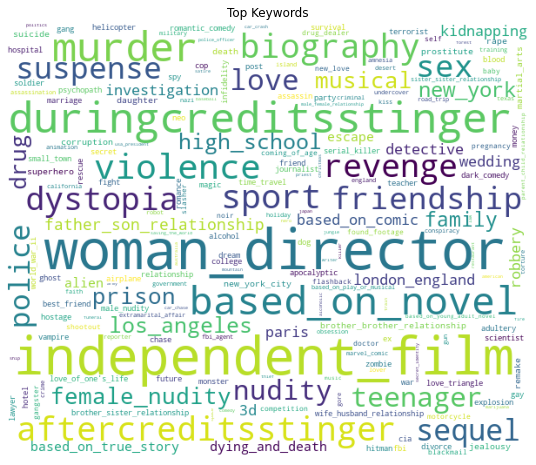

In [0]:
plt.figure(figsize = (12, 8))

text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(background_color='white', collocations=False,
                      height=500, width = 600).generate(text)

plt.imshow(wordcloud)
plt.title('Top Keywords')
plt.axis('off')
plt.show()

In [0]:
#for train data

#making a column to show no. of genres for each movie
train_cp['num_Keywords'] = train_cp['Keywords'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
train_cp['all_Keywords'] = train_cp['Keywords'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#storing the top 15 genres
#most_common returns the touple with text and its frequency
# from it we are extracting only text so m[0]
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]

#making columns of each most freq genre
for g in top_keywords:
  train_cp['keyword_' + g] = train_cp['all_Keywords'].swifter.apply(lambda x:1 if g in x else 0)


#for test data
test_cp['num_Keywords'] = test_cp['Keywords'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

#extracting the genres for the movies and sorting them
test_cp['all_Keywords'] = test_cp['Keywords'].swifter.apply(lambda x:' '.join(sorted([cmp.get('name') for cmp in literal_eval(x)])) if not(pd.isnull(x)) else '')

#making columns of each most freq genre
for g in top_keywords:
  test_cp['keyword_' + g] = test_cp['all_Keywords'].swifter.apply(lambda x:1 if g in x else 0)

#dropping original features
train_cp = train_cp.drop(['Keywords', 'all_Keywords'], axis = 1)
test_cp = test_cp.drop(['Keywords', 'all_Keywords'], axis = 1)

In [0]:
train_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,cast,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,...,languague_עִבְרִית,languague_ελληνικά,languague_Türkçe,languague_Dansk,languague_Nederlands,languague_فارسی,languague_Tiếng Việt,languague_اردو,languague_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,113.0,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,105.0,Released,The road to greatness can take you to the edge.,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
test_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,cast,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,...,languague_עִבְרִית,languague_ελληνικά,languague_Türkçe,languague_Dansk,languague_Nederlands,languague_فارسی,languague_Tiếng Việt,languague_اردو,languague_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3003,0,NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,5/23/97,100.0,Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",0,0,2,Comedy Romance,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#**Cast**

In [0]:
for i, e in enumerate(train_cp['cast'][:5]):
  print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [0]:
print('Casted persons in films grouped by count')
train_cp['cast'].apply(lambda x : len(literal_eval(x)) if not pd.isnull(x) else 0).value_counts().head(10)

Casted persons in films grouped by count


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

* Films that have more cast members impact the quality of the film.
* We were provided with not only the name of the character, but also the gender and character name/type.
* First lets have a look at the popular names.

In [0]:
list_of_cast_names = list(train_cp['cast'].apply(lambda x: [i.get('name') for i in literal_eval(x)] if not pd.isnull(x) else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

* Lets list down the top 15 cast and have a look at them.

In [0]:
list_of_genders = list(train_cp['cast'].apply(lambda x: [i.get('gender') for i in literal_eval(x)] if not pd.isnull(x) else []).values)

Counter([i for j in list_of_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

* '0' is unspecified gender, 1 - female, 2 - male

In [0]:
list_of_cast_characters = list(train_cp['cast'].apply(lambda x: [i.get('character') for i in literal_eval(x)] if not pd.isnull(x) else []).values)

Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

* In the given dataset, actors who played themselves as characters in the films are more.
* We are making a new column that holds the number of cast persons in the movie.
* And the binary columns of top 15 most_common cast names.
* Also making a column that holds the count of three genders from the given cast details.
* Eg: In a given cast, there are 10 males, 15 females and 5 others for a given movie.

In [0]:
#for train data

train_cp['num_cast'] = train_cp['cast'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]

for g in top_cast_names:
  train_cp['cast_name_' + g] = train_cp['cast'].swifter.apply(lambda x:1 if g in str(x) else 0)

train_cp['gender_0_cast'] = train_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 0]) if pd.notna(x) else 0)
train_cp['gender_1_cast'] = train_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 1]) if pd.notna(x) else 0)
train_cp['gender_2_cast'] = train_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 2]) if pd.notna(x) else 0)


top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
  train_cp['cast_character_' + g] = train_cp['cast'].swifter.apply(lambda x:1 if g in str(x) else 0)




#for test data
test_cp['num_cast'] = test_cp['cast'].swifter.apply(lambda x : len(literal_eval(x)) if not (pd.isnull(x)) else 0)

for g in top_cast_names:
  test_cp['cast_name_' + g] = test_cp['cast'].swifter.apply(lambda x:1 if g in str(x) else 0)

test_cp['gender_0_cast'] = test_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 0]) if pd.notna(x) else 0)
test_cp['gender_1_cast'] = test_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 1]) if pd.notna(x) else 0)
test_cp['gender_2_cast'] = test_cp['cast'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 2]) if pd.notna(x) else 0)

for g in top_cast_characters:
  test_cp['cast_character_' + g] = test_cp['cast'].swifter.apply(lambda x:1 if g in str(x) else 0)



#dropping original features
train_cp = train_cp.drop(['cast'], axis = 1)
test_cp = test_cp.drop(['cast'], axis = 1)

In [0]:
train_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,crew,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,...,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,gender_0_cast,gender_1_cast,gender_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,...,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,8,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,113.0,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,105.0,Released,The road to greatness can take you to the edge.,Whiplash,"[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,1,0,0,0,0,51,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,31,7,13,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1


In [0]:
train_cp[['gender_0_cast','gender_1_cast']]

,gender_0_cast,gender_1_cast
0,6,8
1,0,10
2,31,7
3,4,1
4,0,0
...,...,...
2995,1,3
2996,9,1
2997,2,4
2998,1,9


In [0]:
test_cp.head(3)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,crew,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,...,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,gender_0_cast,gender_1_cast,gender_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,2,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,3003,0,NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,5/23/97,100.0,Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'credit_id': '52fe4330c3a36847f8041367', 'de...",0,0,2,Comedy Romance,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,...,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#**Crew**

In [0]:
for i, e in enumerate(train_cp['crew'][:1]):
  print(i, literal_eval(e)[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [0]:
print('Number of crew persons in films')
train_cp['crew'].apply(lambda x: len(x) if pd.notna(x) else 0).value_counts().head(10)

Number of crew persons in films


0      16
376    10
324     9
355     8
326     8
162     7
320     7
378     7
380     7
382     7
Name: crew, dtype: int64

* Great crew is also very important in creating a blockbuster film.
* Fame of crew people like Directors, producers, cameraman play a very important in revenue of the film.
* We have not only the names of the crew members, but also the genders, jobs and departments.
* Lets look at the popular names.

In [0]:
list_of_crew_names = list(train_cp['crew'].apply(lambda x: [i.get('name') for i in literal_eval(x)] if pd.notna(x) else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [0]:
list_of_crew_jobs = list(train_cp['crew'].apply(lambda x: [i.get('job') for i in literal_eval(x)] if pd.notna(x) else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [0]:
list_of_crew_genders = list(train_cp['crew'].apply(lambda x: [i.get('gender') for i in literal_eval(x)] if pd.notna(x) else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [0]:
list_of_crew_departments = list(train_cp['crew'].apply(lambda x: [i.get('department') for i in literal_eval(x)] if pd.notna(x) else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(15)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

* In the given dataset, production crew has large number.
* We are making a new column that holds the number of crew involved in making of the movie.
* And the binary columns of top 15 most_common crew departments eg: production, directing, editing, etc.
* Also making a column that holds the count of three genders from the given crew details.
* Eg: From the given crew details involved in making of the movie, there are 10 males, 15 females and 5 others involved.

In [0]:
#for train data

train_cp['num_crew'] = train_cp['crew'].swifter.apply(lambda x : len(literal_eval(x)) if pd.notna(x) else 0)

top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]


#Crew names
for g in top_crew_names:
  train_cp['crew_name_' + g] = train_cp['crew'].swifter.apply(lambda x:1 if g in str(x) else 0)

train_cp['gender_0_crew'] = train_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 0]) if pd.notna(x) else 0)
train_cp['gender_1_crew'] = train_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 1]) if pd.notna(x) else 0)
train_cp['gender_2_crew'] = train_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 2]) if pd.notna(x) else 0)

#Crew jobs
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]

for g in top_crew_jobs:
  train_cp['jobs_' + g] = train_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('job') == g]) if pd.notna(x) else 0)

#Crew departments
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]

for g in top_crew_departments:
  train_cp['departments_' + g] = train_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('department') == g]) if pd.notna(x) else 0)




#for test data
test_cp['num_crew'] = test_cp['crew'].swifter.apply(lambda x : len(literal_eval(x)) if pd.notna(x) else 0)


#Crew names
for g in top_crew_names:
  test_cp['crew_name_' + g] = test_cp['crew'].swifter.apply(lambda x:1 if g in str(x) else 0)

test_cp['gender_0_crew'] = test_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 0]) if pd.notna(x) else 0)
test_cp['gender_1_crew'] = test_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 1]) if pd.notna(x) else 0)
test_cp['gender_2_crew'] = test_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('gender') == 2]) if pd.notna(x) else 0)

#Crew jobs
for g in top_crew_jobs:
  test_cp['jobs_' + g] = test_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('job') == g]) if pd.notna(x) else 0)

#Crew departments
for g in top_crew_departments:
  test_cp['departments_' + g] = test_cp['crew'].swifter.apply(lambda x: sum([1 for i in literal_eval(x) if i.get('department') == g]) if pd.notna(x) else 0)



#dropping original features
train_cp = train_cp.drop(['crew'], axis = 1)
test_cp = test_cp.drop(['crew'], axis = 1)

In [0]:
train_cp.head(2)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,...,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,gender_0_crew,gender_1_crew,gender_2_crew,jobs_Producer,jobs_Executive Producer,jobs_Director,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,59,0,13,1,3,1,0,1,1,1,1,1,1,1,1,1,4,2,9,10,12,4,2,13,8,4,2,4,4,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,113.0,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,4,4,3,1,1,1,1,0,1,1,0,0,0,0,0,0,0,4,1,0,0,1,0,1,1,1,0,0,0


In [0]:
test_cp.head(2)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Collection_name,has collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),...,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,gender_0_crew,gender_1_crew,gender_2_crew,jobs_Producer,jobs_Executive Producer,jobs_Director,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,3002,88000,NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,0,0,2,Horror Science Fiction,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,6,1,1,1,0,1,0,1,1,0,0,0,1,0,1,0,2,1,0,0,1,1,1,1,1,0,0,0


#Saving the data



NOTE::
* For saving the data to parquet file data in a column should be of same type.
* But in column 'Collection_name', has columns with 0 as values which is integer and the rest are text which is 'str' or 'object'.
* So we are going to fill 0s with NaN in both train and test datasets.

In [0]:
train_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 238 entries, id to departments_Actors
dtypes: float64(2), int64(224), object(12)
memory usage: 5.4+ MB


In [0]:
train_cp['Collection_name'].replace(0, np.nan, inplace=True)
test_cp['Collection_name'].replace(0, np.nan, inplace=True)

* Finally saving the preprocessed data in the google drive.
* This is the initial preprocessing of all columns. Whatever changes we do next, we do on this latest data.
* Also **PROJECT_PATH** is already defined earlier that stores the path to save the files.

In [0]:
train_cp.to_parquet(PROJECT_PATH + '/data/Istage_feat_train.parquet.gzip', compression='gzip')
test_cp.to_parquet(PROJECT_PATH + '/data/Istage_feat_test.parquet.gzip', compression='gzip')